# <span> Laboratorio di Simulazione Numerica  </span>
## <span> Esercitazione 3 </span>
### Esercizio 3.1

Lo scopo di questo esercizio è quello di applicare metodi Monte Carlo ai mercati finanziari, in particolare vogliamo stimare i prezzi delle opzioni europee di tipo call e put, confrontando i valori ottenuti con i risultati analitici della teoria di Black-Scholes. <br>
L'<b>opzione europea</b> è una particolare tipologia di contratto tra due parti in cui uno dei due partner, il venditore, assume l'obbligo, mentre l'altro, il compratore, assume il diritto. Nell'opzione di tipo <b>call</b> il compratore ha il diritto di scegliere se comprare un bene con prezzo corrente $S(t)$ a un prezzo pattuito $K$ oppure no; nell'opzione di tipo <b>put</b> il compratore ha il diritto di scegliere se vendere il bene al prezzo pattuito $K$ oppure no. Questo diritto può essere esercitato solamente in una data nel futuro decisa al momento del contratto. Chiaramente il compratore eserciterà il suo dirito solamente se ci sarà un profitto. Tale profitto è dato da $\max[0,S(T)-K]$ nel caso di una call e da $\max[0,K-S(T)]$ per una put.

Il prezzo dell'opzione può essere calcolato in base a quello che sarà il profitto dell'holder, scontato di un fattore esponenziale dovuto all'ipotetico tasso di interesse che un eventuale deposito in banca avrebbe garantito. Indicando i prezzi della call e della put rispettivamente con $C[S(0),0]$ e $P[S(0),0]$, questi sono dati dalle seguenti relazioni 

$$C[S(0),0]=<e^{-rT}\max[0,S(T)-K]> \;\;\;\;\;\;\;\;\;\;\;\;\;  P[S(0),0]=<e^{-rT}\max[0,K-S(T)]>$$

L'unica cosa che dobbiamo calcolare è quindi il prezzo del bene al tempo di scadenza. Nelle ipotesi della teoria di Black-Scholes il prezzo dei beni è una variabile stocastica che segue un moto Browniano geometrico con drift $r$ e volatilità $\sigma$: noto il prezzo del bene iniziale, al tempo finale questo è dato da

\begin{equation*}
S(T) = S(0) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)T+\sigma W(T)\right] = S(0) \exp \left[ \left(r-\frac{1}{2}\sigma^2\right)T+\sigma Z(T)\sqrt{T}\right]
\label{direct} \tag{1}
\end{equation*}

dove $W(t)$ è una variabile casuale distribuita secondo una Gaussiana con media nulla e varianza $T$, ovvero $W(t)\sim\mathcal{N}(0,T)$, mentre $Z(T) \sim \mathcal{N}(0,1)$.

Siccome gli incrementi di $W$ sono statisticamente indipendenti e normalmente distribuiti, è possibile discretizzare il moto Browniano senza commettere errori. Viene quindi diviso l'intervallo temporale $[0,T]$ in $100$ step temporali e viene calcolato il prezzo a ogni step tramite la formula

\begin{equation*}
S(t_{i+1}) = S(t_i) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)+\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]
\label{discrete} \tag{2}
\end{equation*}

dove $Z_i \sim \mathcal{N}(0,1)$. <br>

Il calcolo del prezzo finale avviene quindi in due modi: il primo è quello diretto tramite la $\eqref{direct}$, mentre il secondo è quello discreto tramite la $\eqref{discrete}$.

Per implementare il codice di questo esercizio si utilizza la programmazione a oggetti di C++. È stata creata la classe <b>BrownianMotion</b>, che presenta come membri privati un puntatore alla classe Random, la volatilità e il drift. Il prezzo dell'opzione viene calcolato tramite il metodo <b>GBM</b>, dove viene implementato il moto Browniano geometrico: a seconda dei parametri di input viene effettuato il campionamento diretto o il campionamento discretizzato. 

Per la simulazione vengono usati i seguenti parametri:

- prezzo del bene a $t=0$: $S(0)=100$
- tempo di scadenza: $T=1$
- prezzo di esercizio: $K=100$
- tasso di interesse privo di rischio: $r=0.1$
- volatilità: $\sigma=0.25$

La stima dei prezzi delle opzioni con la relativa incertezza avviene tramite il metodo del data blocking, dividendo le $4 \cdot 10^4$ stime dei prezzi in $400$ blocchi. Per le due opzioni call e put viene riportata la differenza tra i prezzi simulati, con il relativo errore statistico, e il risultato analitico al variare del numero di blocchi sia per il campionamento diretto che per quello discretizzato. Nel secondo script di python è presente il calcolo analitico dei prezzi delle opzioni.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import scipy
from scipy.special import erf
from scipy import log, exp, sqrt

%config InlineBackend.figure_format = 'retina'

In [2]:
# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / np.sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * np.sqrt(T)
    C = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * np.exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call)
    print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


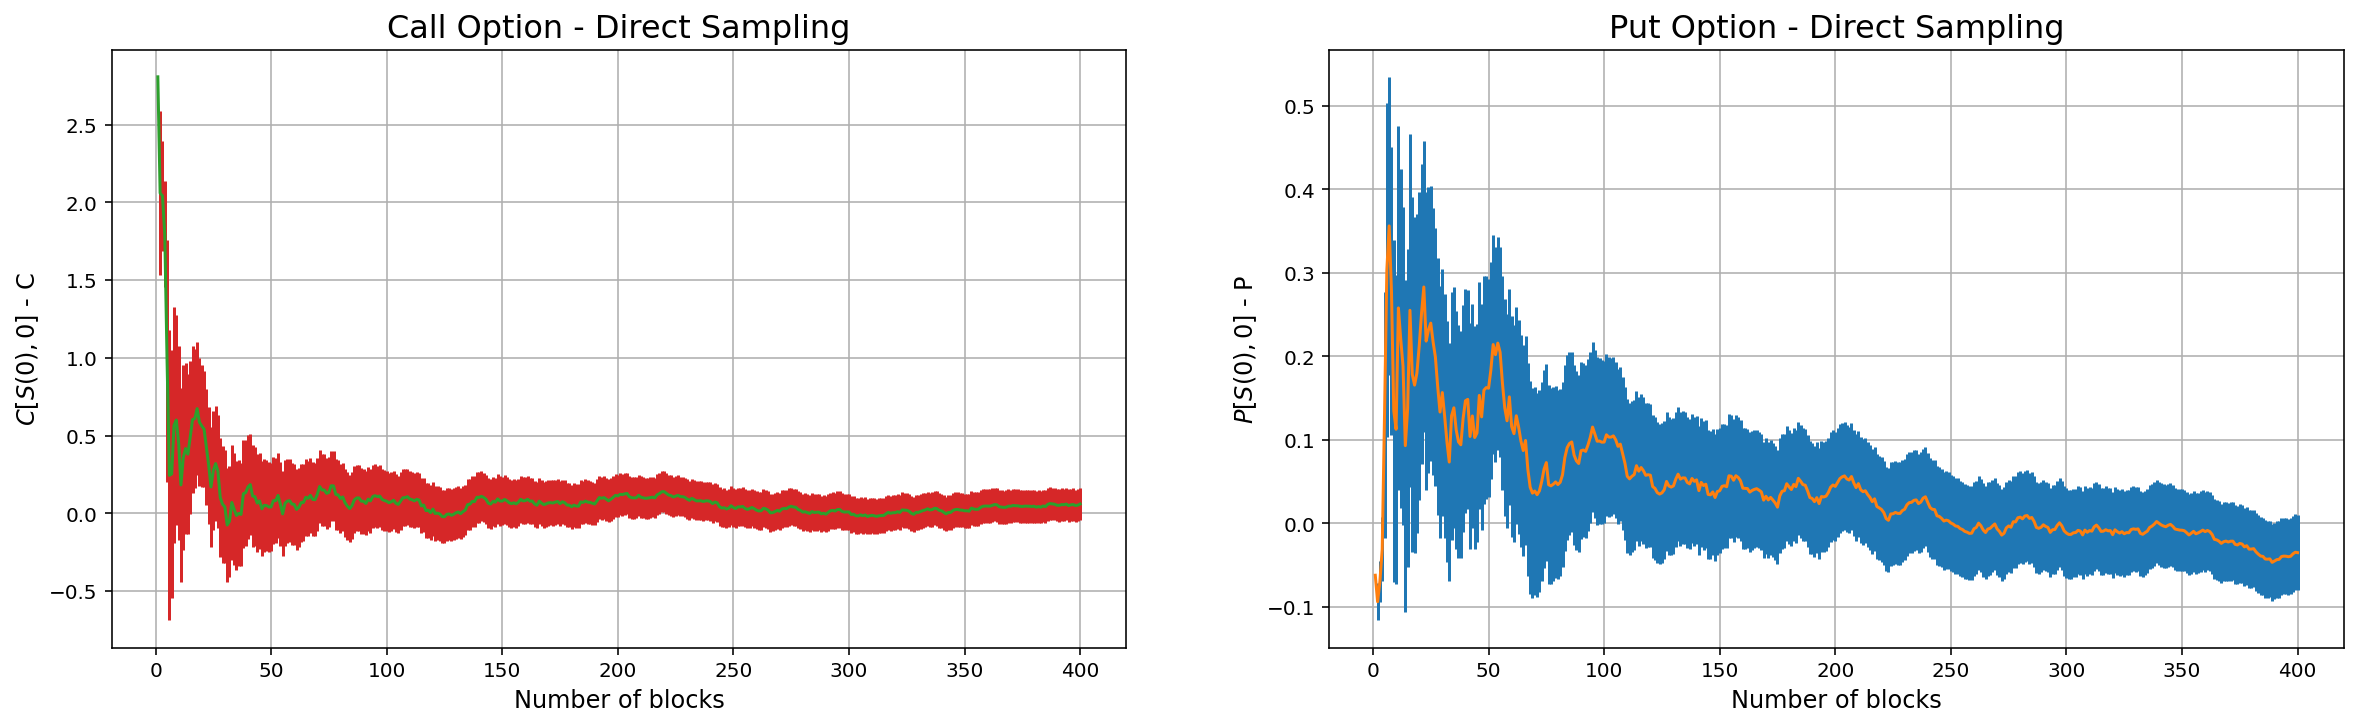

In [3]:
x, direct_call, err_direct_call = np.loadtxt("3.1/direct_call.out", usecols=(0,1,2), delimiter=' ', unpack='true')
direct_put, err_direct_put = np.loadtxt("3.1/direct_put.out", usecols=(1,2), delimiter=' ', unpack='true')

fig, ax = plt.subplots(1, 2, figsize=(20, 5.5))
ax = ax.reshape(-1)

ax[0].errorbar(x, direct_call-call, yerr=err_direct_call, color="tab:green", ecolor="tab:red")
ax[0].set_xlabel(r'Number of blocks', fontsize=12)
ax[0].set_ylabel(r'$C[S(0), 0]$ - C', fontsize=12)
ax[0].set_title(f"Call Option - Direct Sampling", fontsize=16)
ax[0].grid(True)

ax[1].errorbar(x, direct_put-put, yerr=err_direct_put, color="tab:orange", ecolor="tab:blue")
ax[1].set_xlabel(r'Number of blocks', fontsize=12)
ax[1].set_ylabel(r'$P[S(0), 0]$ - P', fontsize=12)
ax[1].set_title(f"Put Option - Direct Sampling", fontsize=16)
ax[1].grid(True)

plt.show()

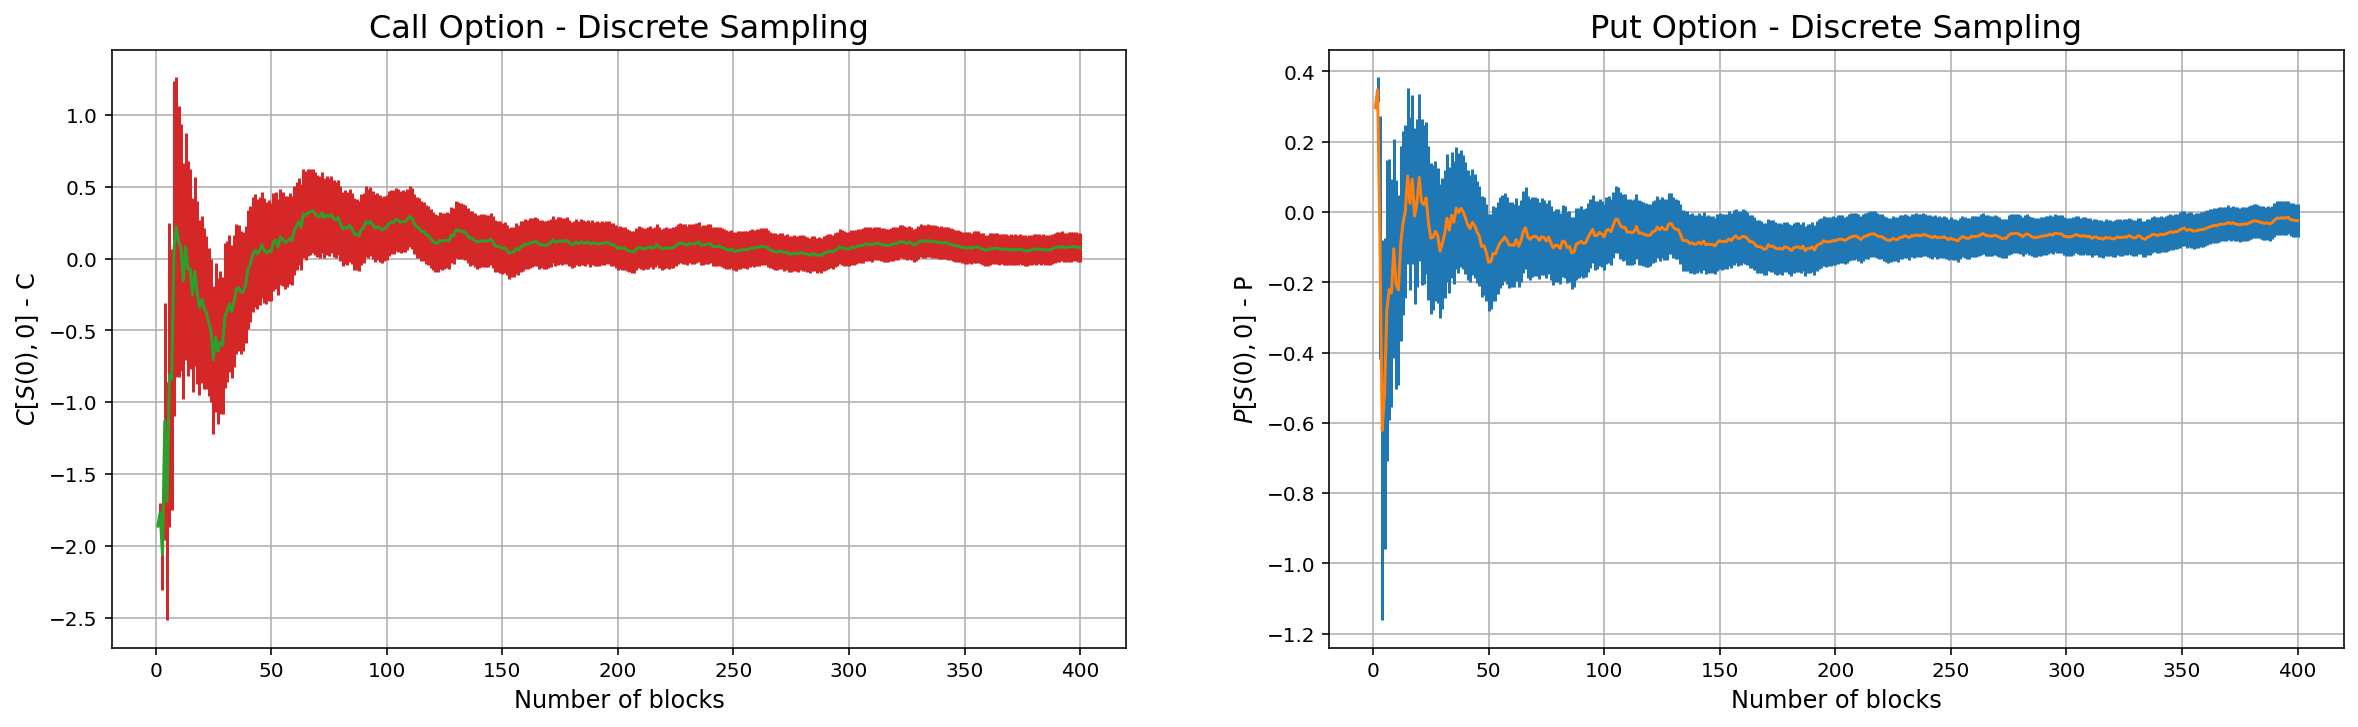

In [4]:
discrete_call, err_discrete_call = np.loadtxt("3.1/discrete_call.out", usecols=(1,2), delimiter=' ', unpack='true')
discrete_put, err_discrete_put = np.loadtxt("3.1/discrete_put.out", usecols=(1,2), delimiter=' ', unpack='true')

fig, ax = plt.subplots(1, 2, figsize=(20, 5.5))
ax = ax.reshape(-1)

ax[0].errorbar(x, discrete_call-call, yerr=err_discrete_call, color="tab:green", ecolor="tab:red")
ax[0].set_xlabel(r'Number of blocks', fontsize=12)
ax[0].set_ylabel(r'$C[S(0), 0]$ - C', fontsize=12)
ax[0].set_title(f"Call Option - Discrete Sampling", fontsize=16)
ax[0].grid(True)

ax[1].errorbar(x, discrete_put-put, yerr=err_discrete_put, color="tab:orange", ecolor="tab:blue")
ax[1].set_xlabel(r'Number of blocks', fontsize=12)
ax[1].set_ylabel(r'$P[S(0), 0]$ - P', fontsize=12)
ax[1].set_title(f"Put Option - Discrete Sampling", fontsize=16)
ax[1].grid(True)

plt.show()

In tutti e quattro i casi i prezzi calcolati numericamente sono compatibili con la soluzione analitica entro l'errore statistico.